In [11]:
# data
from sklearn.datasets import make_blobs

# preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# plotting
import matplotlib.pyplot as plt

# mathematical
import numpy as np
import tensorflow as tf


# modelling
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

# other
from time import time




# global vars
random_state = 1




In [2]:
# plotting functions

def plot_classes(X,y, ax = None):

    """
    Given X and y, where X represents the X values (in 2D) and y the classes,
    plots outcomes with different colors.
    """
    
    if ax:
        pass
    else:
        fig, ax = plt.subplots()
    for y_unique in np.unique(y):
        ax.plot(X[y == y_unique, 0], X[y == y_unique, 1], '.')
    return fig, ax

Text(0, 0.5, 'attribute 2')

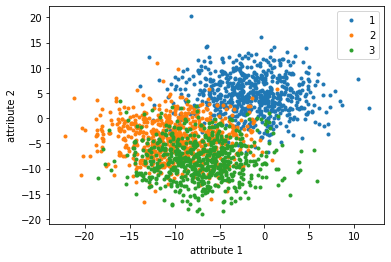

In [3]:
X,y = make_blobs(2000, cluster_std = 4, random_state = random_state)
y_categ = to_categorical(y)
fig, ax = plot_classes(X, y)
plt.legend([1,2,3])
plt.xlabel('attribute 1')
plt.ylabel('attribute 2')

# Train_test_split()

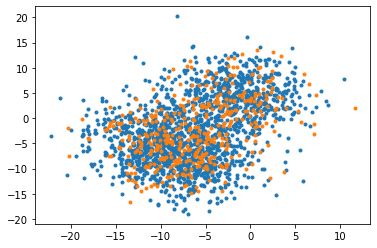

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categ,
                                                    test_size = 0.2,
                                                    random_state = random_state)

plt.plot(X_train[:,0],X_train[:,1],'.')
plt.plot(X_test[:,0],X_test[:,1],'.')

In [8]:
# modelling functions

def uncompiled_model(n_attr = 2, classes = 3):
    
    """
    Creates the architecture for a neural netowrk given the conditions of the data
    going in and coming out
    """
    
    # define input layer
    inputs = Input(shape=(n_attr,), name='InputLayer')
    
    # define hidden layers
    x = Dense(256, activation = 'tanh')(inputs)
    x = Dense(128, activation = 'tanh')(x)
    x = Dense(64, activation = 'tanh')(x)
    x = Dense(8, activation = 'tanh')(x)
    x = Dense(4, activation = 'tanh')(x)




    # define output layer
    outputs = Dense(classes, activation='softmax')(x)
    
    # create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

def compile_model(**kwargs):
    """
    Compiles model from 'uncompiled_model'
    """
    
    # create model
    model = uncompiled_model(**kwargs)
    
    # compile model
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model



13/13 [==============================] - 0s 5ms/step - loss: 0.7283 - accuracy: 0.7500


[0.7282778024673462, 0.75]

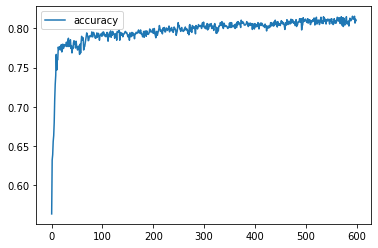

In [6]:
model = compile_model()
history = model.fit(X_train, y_train, verbose = 0, epochs = 600, batch_size = 128)
plt.plot(history.history['accuracy'])
plt.legend(['accuracy'])
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.4021 - accuracy: 0.8375


[0.4021448791027069, 0.8374999761581421]

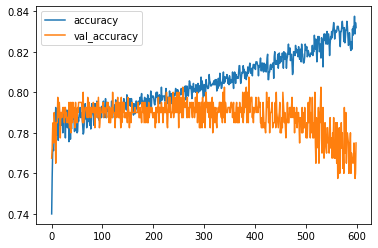

In [9]:
model = compile_model()

history = model.fit(X, y_categ,
                    validation_split = 0.2,
                    verbose = 0,
                    epochs = 600,
                    batch_size = 128)
                    #shuffle = True)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])

model.evaluate(X_test, y_test)

In [12]:
def cross_validate(K = 5, **kwargs):
    scores = []
    histories = []
    X = np.concatenate((X_train, X_test), axis = 0)
    y = np.concatenate((y_train, y_test), axis = 0)
    for train, test in KFold(n_splits=K, shuffle=True).split(X,y):
        model = compile_model()
        start = time()
        histories.append(model.fit(X[train], y[train],
                                   validation_data = (X[test],y[test]),
                                   **kwargs).history)
        print(time() - start)
        scores.append(model.evaluate(X[test], y[test], verbose = 0))
    print("average loss: ", np.asarray(scores)[:,0].mean())
    print("average accuracy: ", np.asarray(scores)[:,1].mean()) # make sure that accuracy is the first metric in compile
    print(model.summary())
    #model = compile_model()
    #model.fit(data[0],data[2],**kwargs)
    #print(model.evaluate(data[1],data[3]))
    return scores, histories

def plot_histories(histories, metrics = ['loss', 'accuracy', 'val_accuracy','val_loss']):
    fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2, figsize = (16,16))
    axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)
    for i,metric in enumerate(metrics):
        for history in histories:
            axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history[metric])
            axes[(i+2)//2 - 1, 1 - (i+1)%2].legend([i for i in range(len(histories))])


            #axes[(i+2)//2 - 1, 1 - (i+1)%2].axhline(y=max(history[metric]))
            axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticks(
                np.arange(max(history[metric]))
            )

In [13]:
scores, histories = cross_validate(K = 5, 
                                   epochs = 600,
                                   # set to 1000 for good performance on YOUR model
                                   verbose = 0,
                                   batch_size = 128, # best when set to 50, 128 does not work bad either? So does 156! Early stopping will probably really help you model !
                                   # set to 128 for your model
                                   shuffle = True)

29.569403171539307
29.558543920516968
29.93910312652588
27.317368984222412
27.884035110473633
average loss:  0.6594597339630127
average accuracy:  0.7544999957084656
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_43 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_46 (Dense)   

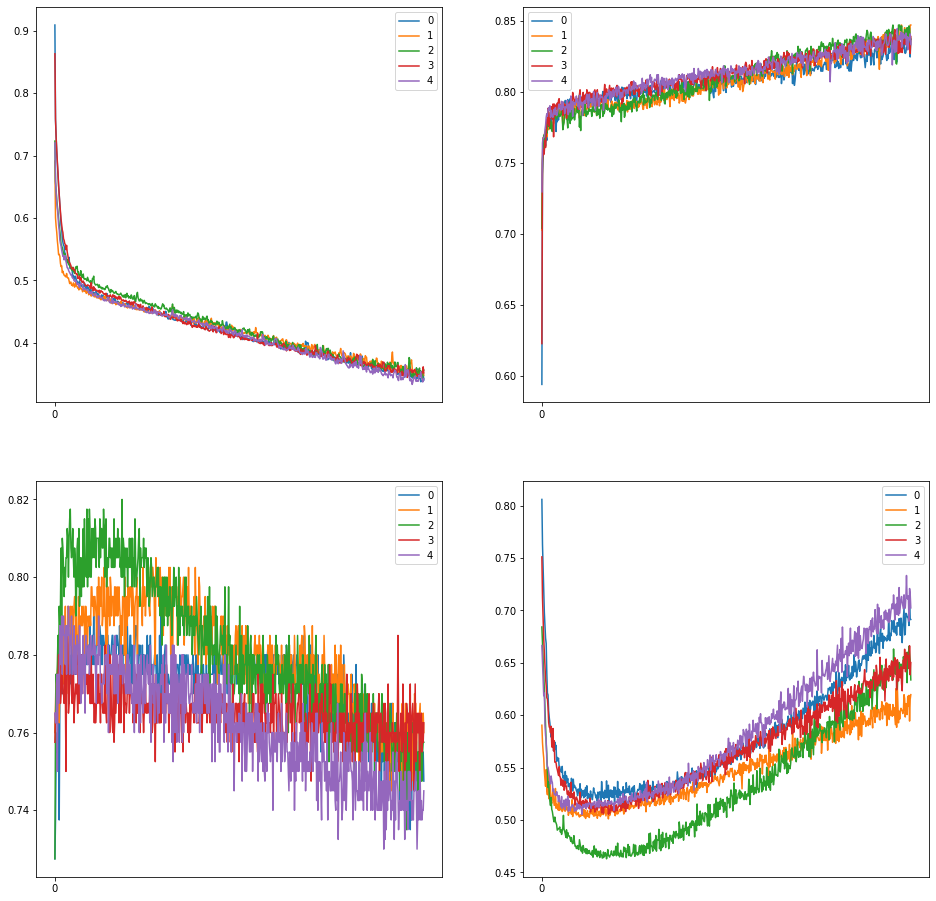

In [14]:
plot_histories(histories)